In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
df = pd.read_pickle('testingdf2.pkl')
df = df.replace(pd.NA, np.nan)
df

,76561198153524465,76561198041864324,76561198110981529,76561198078042697,76561198072956091,76561198044215451,76561198117910816,76561198067369254,76561198095881349,76561198160606109,...,76561198064051588,76561198065637682,76561198093942856,76561198084283944,76561198068872077,76561198090802478,76561198068470798,76561198098128800,76561198098303003,76561198060478569
570,NaN,71.0,271784.0,370587.0,30.0,127.0,NaN,68001.0,28686.0,NaN,...,62.0,NaN,15850.0,NaN,11081.0,NaN,NaN,17.0,11848.0,NaN
1172470,NaN,1740.0,NaN,NaN,422.0,2519.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
730,52631.0,156473.0,NaN,218577.0,56384.0,17022.0,NaN,2826.0,NaN,0.0,...,10009.0,102617.0,16021.0,9316.0,134.0,NaN,NaN,NaN,NaN,NaN
578080,7881.0,1317.0,NaN,0.0,0.0,NaN,NaN,105578.0,NaN,0.0,...,8200.0,0.0,187.0,129.0,NaN,0.0,NaN,NaN,NaN,NaN
1063730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1259970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# This cell removes all zeroes from the dataframe, if uncommented.

df = df.replace(np.nan, 0)
df = df.replace(0, np.nan)
df

,76561198153524465,76561198041864324,76561198110981529,76561198078042697,76561198072956091,76561198044215451,76561198117910816,76561198067369254,76561198095881349,76561198160606109,...,76561198064051588,76561198065637682,76561198093942856,76561198084283944,76561198068872077,76561198090802478,76561198068470798,76561198098128800,76561198098303003,76561198060478569
570,NaN,71.0,271784.0,370587.0,30.0,127.0,NaN,68001.0,28686.0,NaN,...,62.0,NaN,15850.0,NaN,11081.0,NaN,NaN,17.0,11848.0,NaN
1172470,NaN,1740.0,NaN,NaN,422.0,2519.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
730,52631.0,156473.0,NaN,218577.0,56384.0,17022.0,NaN,2826.0,NaN,NaN,...,10009.0,102617.0,16021.0,9316.0,134.0,NaN,NaN,NaN,NaN,NaN
578080,7881.0,1317.0,NaN,NaN,NaN,NaN,NaN,105578.0,NaN,NaN,...,8200.0,NaN,187.0,129.0,NaN,NaN,NaN,NaN,NaN,NaN
1063730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1259970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
class MFRecommender():
    """
    Matrix factorization recommender model object.
    
    Attributes:
        game_weights (np.array): matrix of weights corresponding to user 
            profile weights for each game.
        user_weights (np.array): matrix of weights corresponding to how to 
            represent each user as a linear combination of user profiles.
        filled_entries (List[tuple(int)]): list of index pairs (i,j) of the
            non-null entries of df. 
        lr (float): learning rate
        l2 (float): size of the l2 penalty when fitting and predicting.
        df (pd.DataFrame): pandas dataframe representing the sparse matrix
            of data
    """
    
    
    def __init__(self, df, k=7, lr=0.0001, l2=0.1, val_split=0.15):
        """
        Initializes the model.
        
        Args:
            df (pd.DataFrame): sparse dataframe of user playtime info.
            k (int): Number of user profiles for the model.
            lr (float): learning rate for SGD.
            l2 (float): l2 penalty for training the weights.
        """
        self.df = df
        self.game_weights = np.random.rand(df.shape[0],k)
        self.user_weights = np.random.rand(k, df.shape[1])
        self.filled_entries = []
        self.lr = lr
        self.l2 = l2
        for i in range(df.shape[0]):
            for j in range(df.shape[1]):
                if not pd.isna(df.iat[i,j]):
                    self.filled_entries.append((i,j))
        self.fe_train, self.fe_valid = train_test_split(self.filled_entries, 
                                                       test_size=val_split)
        
    
    
    def fit(self, epochs):
        """
        Fits the model a certain number of epochs based on the df provided.
        Args:
            epochs (int): number of epochs to train the model
        """
        for k in range(epochs):
            print('Fitting epoch {}...'.format(k+1))
            pred = np.matmul(self.game_weights, self.user_weights)
            t_game_weights = np.copy(self.game_weights)
            t_user_weights = np.copy(self.user_weights)
            
            # apply l2 penalty
            self.game_weights = t_game_weights*(1 - self.lr*self.l2)
            self.user_weights = t_user_weights*(1 - self.lr*self.l2)
            
            # Update with SGD
            for i, j in self.fe_train:
                for l in range(self.user_weights.shape[0]):
                    diff = (self.df.iat[i,j]-pred[i,j])
                    self.game_weights[i,l] += self.lr*t_user_weights[l,j]*diff
                    self.user_weights[l,j] += self.lr*t_game_weights[i,l]*diff
            print('Train MSE = {:.5f}     '.format(self.train_MSE())
                 + 'Validation MSE = {:.5f}'.format(self.valid_MSE()))
    
    
    def train_loss(self):
        loss = 0
        pred = np.matmul(self.game_weights, self.user_weights)
        for i, j in self.fe_train:
            # print(self.df.iat[i,j], pred[i,j])
            loss += (self.df.iat[i,j] - pred[i,j])**2
        return loss
    
    def valid_loss(self):
        loss = 0
        pred2 = np.matmul(self.game_weights, self.user_weights)
        for i, j in self.fe_valid:
            # print(self.df.iat[i,j], pred[i,j])
            loss += (self.df.iat[i,j] - pred2[i,j])**2
        return loss
    
    def train_MSE(self):
        loss = 0
        pred2 = np.matmul(self.game_weights, self.user_weights)
        for i, j in self.fe_train:
            # print(self.df.iat[i,j], pred[i,j])
            loss += (self.df.iat[i,j] - pred2[i,j])**2
        return loss/len(self.fe_train)
    
    def valid_MSE(self):
        loss = 0
        pred2 = np.matmul(self.game_weights, self.user_weights)
        for i, j in self.fe_valid:
            # print(self.df.iat[i,j], pred[i,j])
            loss += (self.df.iat[i,j] - pred2[i,j])**2
        return loss/len(self.fe_valid)
    
    def predict(self, user_data, epochs=100):
        """
        Given the data for a user, returns the predicted playtime series.
        
        Args:
            user_data (pd.series): sparse pandas series of user playtime
        
        Returns (pd.series): filled pandas series of predicted playtime.
        """
        user_profile = np.random.rand(self.user_weights.shape[0], 1)
        
        filled_indices = []
        for j in range(user_data.shape[0]):
            if not pd.isna(user_data.iat[j]):
                filled_indices.append(j)
        
        for j in range(epochs):
            #print('Fitting epoch {}...'.format(k+1))
            pred2 = np.matmul(self.game_weights, user_profile)
            #print(pred)
            t_user_weights = np.copy(user_profile)
            
            # apply l2 penalty
            user_profile = t_user_weights*(1 - self.lr*self.l2)
            
            # Update with SGD
            for i in filled_indices:
                for l in range(self.user_weights.shape[0]):
                    diff = (user_data.iat[i]-pred2[i])
                    user_profile[l] += self.lr*self.game_weights[i,l]*diff
        
        # return final prediction, converted to pandas
        to_return = user_data.copy()
        pred2 = np.matmul(self.game_weights, user_profile)
        for j in range(to_return.shape[0]):
            to_return.iat[j] = pred2[j]
            
        loss = 0
        for i in filled_indices:
            # print(self.df.iat[i,j], pred[i,j])
            loss += (user_data.iat[i] - pred2[i])**2
        print('MSE: {}'.format(loss/len(filled_indices)))
        return to_return
                
                
                
        

In [5]:
# Note that the outliers in the data will prevent convergence unless we log-normalize first.

log_df = df.applymap(lambda x: np.log10(x+1) if not np.isnan(x) else x)
log_df

,76561198153524465,76561198041864324,76561198110981529,76561198078042697,76561198072956091,76561198044215451,76561198117910816,76561198067369254,76561198095881349,76561198160606109,...,76561198064051588,76561198065637682,76561198093942856,76561198084283944,76561198068872077,76561198090802478,76561198068470798,76561198098128800,76561198098303003,76561198060478569
570,NaN,1.857332,5.434225,5.568891,1.491362,2.107210,NaN,4.832522,4.457685,NaN,...,1.799341,NaN,4.200057,NaN,4.044618,NaN,NaN,1.255273,4.073682,NaN
1172470,NaN,3.240799,NaN,NaN,2.626340,3.401401,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
730,4.721250,5.194442,NaN,5.339606,4.751164,4.231036,NaN,3.451326,NaN,NaN,...,4.000434,5.011224,4.204717,3.969276,2.130334,NaN,NaN,NaN,NaN,NaN
578080,3.896636,3.119915,NaN,NaN,NaN,NaN,NaN,5.023578,NaN,NaN,...,3.913867,NaN,2.274158,2.113943,NaN,NaN,NaN,NaN,NaN,NaN
1063730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1259970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
models = []
for k in [7, 4]:
    print('Training model with k={}.'.format(k))
    clf = MFRecommender(log_df, k, lr=0.0001, l2=0)
    clf.fit(200)
    models.append(clf)

Training model with k=7.
Fitting epoch 1...
Train MSE = 1.59081     Validation MSE = 1.58047
Fitting epoch 2...
Train MSE = 1.40550     Validation MSE = 1.39673
Fitting epoch 3...
Train MSE = 1.28883     Validation MSE = 1.28153
Fitting epoch 4...
Train MSE = 1.20603     Validation MSE = 1.20003
Fitting epoch 5...
Train MSE = 1.14310     Validation MSE = 1.13828
Fitting epoch 6...
Train MSE = 1.09307     Validation MSE = 1.08932
Fitting epoch 7...
Train MSE = 1.05200     Validation MSE = 1.04924
Fitting epoch 8...
Train MSE = 1.01747     Validation MSE = 1.01563
Fitting epoch 9...
Train MSE = 0.98789     Validation MSE = 0.98693
Fitting epoch 10...
Train MSE = 0.96220     Validation MSE = 0.96206
Fitting epoch 11...
Train MSE = 0.93961     Validation MSE = 0.94026
Fitting epoch 12...
Train MSE = 0.91955     Validation MSE = 0.92096
Fitting epoch 13...
Train MSE = 0.90161     Validation MSE = 0.90373
Fitting epoch 14...
Train MSE = 0.88544     Validation MSE = 0.88825
Fitting epoch 15..

Train MSE = 0.62947     Validation MSE = 0.65897
Fitting epoch 120...
Train MSE = 0.62913     Validation MSE = 0.65875
Fitting epoch 121...
Train MSE = 0.62880     Validation MSE = 0.65853
Fitting epoch 122...
Train MSE = 0.62848     Validation MSE = 0.65831
Fitting epoch 123...
Train MSE = 0.62816     Validation MSE = 0.65810
Fitting epoch 124...
Train MSE = 0.62784     Validation MSE = 0.65790
Fitting epoch 125...
Train MSE = 0.62753     Validation MSE = 0.65769
Fitting epoch 126...
Train MSE = 0.62723     Validation MSE = 0.65750
Fitting epoch 127...
Train MSE = 0.62692     Validation MSE = 0.65730
Fitting epoch 128...
Train MSE = 0.62663     Validation MSE = 0.65711
Fitting epoch 129...
Train MSE = 0.62634     Validation MSE = 0.65692
Fitting epoch 130...
Train MSE = 0.62605     Validation MSE = 0.65674
Fitting epoch 131...
Train MSE = 0.62577     Validation MSE = 0.65656
Fitting epoch 132...
Train MSE = 0.62549     Validation MSE = 0.65639
Fitting epoch 133...
Train MSE = 0.62522 

Train MSE = 0.77245     Validation MSE = 0.80448
Fitting epoch 38...
Train MSE = 0.76606     Validation MSE = 0.79843
Fitting epoch 39...
Train MSE = 0.76003     Validation MSE = 0.79272
Fitting epoch 40...
Train MSE = 0.75433     Validation MSE = 0.78734
Fitting epoch 41...
Train MSE = 0.74894     Validation MSE = 0.78225
Fitting epoch 42...
Train MSE = 0.74385     Validation MSE = 0.77744
Fitting epoch 43...
Train MSE = 0.73902     Validation MSE = 0.77289
Fitting epoch 44...
Train MSE = 0.73443     Validation MSE = 0.76858
Fitting epoch 45...
Train MSE = 0.73009     Validation MSE = 0.76449
Fitting epoch 46...
Train MSE = 0.72595     Validation MSE = 0.76060
Fitting epoch 47...
Train MSE = 0.72203     Validation MSE = 0.75691
Fitting epoch 48...
Train MSE = 0.71829     Validation MSE = 0.75340
Fitting epoch 49...
Train MSE = 0.71473     Validation MSE = 0.75006
Fitting epoch 50...
Train MSE = 0.71133     Validation MSE = 0.74688
Fitting epoch 51...
Train MSE = 0.70809     Validation

Train MSE = 0.61903     Validation MSE = 0.66454
Fitting epoch 156...
Train MSE = 0.61883     Validation MSE = 0.66439
Fitting epoch 157...
Train MSE = 0.61863     Validation MSE = 0.66424
Fitting epoch 158...
Train MSE = 0.61844     Validation MSE = 0.66410
Fitting epoch 159...
Train MSE = 0.61824     Validation MSE = 0.66396
Fitting epoch 160...
Train MSE = 0.61805     Validation MSE = 0.66382
Fitting epoch 161...
Train MSE = 0.61787     Validation MSE = 0.66368
Fitting epoch 162...
Train MSE = 0.61768     Validation MSE = 0.66354
Fitting epoch 163...
Train MSE = 0.61750     Validation MSE = 0.66341
Fitting epoch 164...
Train MSE = 0.61732     Validation MSE = 0.66328
Fitting epoch 165...
Train MSE = 0.61715     Validation MSE = 0.66316
Fitting epoch 166...
Train MSE = 0.61697     Validation MSE = 0.66303
Fitting epoch 167...
Train MSE = 0.61680     Validation MSE = 0.66291
Fitting epoch 168...
Train MSE = 0.61664     Validation MSE = 0.66279
Fitting epoch 169...
Train MSE = 0.61647 

In [21]:
models2 = []
for l2 in [0.001, 1, 100]:
    print('Training model with l2={}.'.format(l2))
    clf = MFRecommender(log_df, 7, lr=0.0001, l2=l2)
    clf.fit(50)
    models2.append(clf)

Training model with l2=0.001.
Fitting epoch 1...
Train MSE = 1.56361     Validation MSE = 1.56350
Fitting epoch 2...
Train MSE = 1.39335     Validation MSE = 1.39583
Fitting epoch 3...
Train MSE = 1.28479     Validation MSE = 1.28882
Fitting epoch 4...
Train MSE = 1.20629     Validation MSE = 1.21158
Fitting epoch 5...
Train MSE = 1.14569     Validation MSE = 1.15211
Fitting epoch 6...
Train MSE = 1.09689     Validation MSE = 1.10437
Fitting epoch 7...
Train MSE = 1.05643     Validation MSE = 1.06488
Fitting epoch 8...
Train MSE = 1.02212     Validation MSE = 1.03149
Fitting epoch 9...
Train MSE = 0.99255     Validation MSE = 1.00279
Fitting epoch 10...
Train MSE = 0.96673     Validation MSE = 0.97777
Fitting epoch 11...
Train MSE = 0.94393     Validation MSE = 0.95574
Fitting epoch 12...
Train MSE = 0.92364     Validation MSE = 0.93616
Fitting epoch 13...
Train MSE = 0.90544     Validation MSE = 0.91864
Fitting epoch 14...
Train MSE = 0.88902     Validation MSE = 0.90286
Fitting epoch

Train MSE = 0.99987     Validation MSE = 1.01888
Fitting epoch 20...
Train MSE = 0.99340     Validation MSE = 1.01282
Fitting epoch 21...
Train MSE = 0.98766     Validation MSE = 1.00749
Fitting epoch 22...
Train MSE = 0.98257     Validation MSE = 1.00281
Fitting epoch 23...
Train MSE = 0.97809     Validation MSE = 0.99873
Fitting epoch 24...
Train MSE = 0.97416     Validation MSE = 0.99520
Fitting epoch 25...
Train MSE = 0.97072     Validation MSE = 0.99216
Fitting epoch 26...
Train MSE = 0.96775     Validation MSE = 0.98957
Fitting epoch 27...
Train MSE = 0.96520     Validation MSE = 0.98740
Fitting epoch 28...
Train MSE = 0.96303     Validation MSE = 0.98561
Fitting epoch 29...
Train MSE = 0.96122     Validation MSE = 0.98417
Fitting epoch 30...
Train MSE = 0.95973     Validation MSE = 0.98306
Fitting epoch 31...
Train MSE = 0.95855     Validation MSE = 0.98224
Fitting epoch 32...
Train MSE = 0.95765     Validation MSE = 0.98169
Fitting epoch 33...
Train MSE = 0.95701     Validation

In [23]:
for l2 in [0.1, 10]:
    print('Training model with l2={}.'.format(l2))
    clf = MFRecommender(log_df, 7, lr=0.0001, l2=l2)
    clf.fit(50)
    models2.append(clf)

Training model with l2=0.1.
Fitting epoch 1...
Train MSE = 1.58900     Validation MSE = 1.58542
Fitting epoch 2...
Train MSE = 1.41392     Validation MSE = 1.41232
Fitting epoch 3...
Train MSE = 1.29951     Validation MSE = 1.29975
Fitting epoch 4...
Train MSE = 1.21680     Validation MSE = 1.21852
Fitting epoch 5...
Train MSE = 1.15334     Validation MSE = 1.15624
Fitting epoch 6...
Train MSE = 1.10261     Validation MSE = 1.10646
Fitting epoch 7...
Train MSE = 1.06083     Validation MSE = 1.06548
Fitting epoch 8...
Train MSE = 1.02562     Validation MSE = 1.03095
Fitting epoch 9...
Train MSE = 0.99543     Validation MSE = 1.00134
Fitting epoch 10...
Train MSE = 0.96916     Validation MSE = 0.97560
Fitting epoch 11...
Train MSE = 0.94605     Validation MSE = 0.95296
Fitting epoch 12...
Train MSE = 0.92552     Validation MSE = 0.93286
Fitting epoch 13...
Train MSE = 0.90715     Validation MSE = 0.91488
Fitting epoch 14...
Train MSE = 0.89058     Validation MSE = 0.89870
Fitting epoch 1

In [24]:
for l2 in [0.01]:
    print('Training model with l2={}.'.format(l2))
    clf = MFRecommender(log_df, 7, lr=0.0001, l2=l2)
    clf.fit(50)
    models2.append(clf)

Training model with l2=0.01.
Fitting epoch 1...
Train MSE = 1.60809     Validation MSE = 1.60317
Fitting epoch 2...
Train MSE = 1.42614     Validation MSE = 1.42287
Fitting epoch 3...
Train MSE = 1.30865     Validation MSE = 1.30677
Fitting epoch 4...
Train MSE = 1.22403     Validation MSE = 1.22353
Fitting epoch 5...
Train MSE = 1.15912     Validation MSE = 1.15994
Fitting epoch 6...
Train MSE = 1.10723     Validation MSE = 1.10928
Fitting epoch 7...
Train MSE = 1.06452     Validation MSE = 1.06769
Fitting epoch 8...
Train MSE = 1.02856     Validation MSE = 1.03274
Fitting epoch 9...
Train MSE = 0.99777     Validation MSE = 1.00286
Fitting epoch 10...
Train MSE = 0.97104     Validation MSE = 0.97695
Fitting epoch 11...
Train MSE = 0.94757     Validation MSE = 0.95422
Fitting epoch 12...
Train MSE = 0.92676     Validation MSE = 0.93409
Fitting epoch 13...
Train MSE = 0.90817     Validation MSE = 0.91612
Fitting epoch 14...
Train MSE = 0.89144     Validation MSE = 0.89998
Fitting epoch 

In [17]:
print('Training model with k={}.'.format(k))
clf = MFRecommender(log_df, k, lr=0.00005, l2=0)
clf.fit(200)
models.append(clf)

Training model with k=20.
Fitting epoch 1...
Train MSE = 5.28455     Validation MSE = 5.29958
Fitting epoch 2...
Train MSE = 4.16548     Validation MSE = 4.18814
Fitting epoch 3...
Train MSE = 3.45600     Validation MSE = 3.48198
Fitting epoch 4...
Train MSE = 2.96329     Validation MSE = 2.99100
Fitting epoch 5...
Train MSE = 2.60225     Validation MSE = 2.63094
Fitting epoch 6...
Train MSE = 2.32774     Validation MSE = 2.35703
Fitting epoch 7...
Train MSE = 2.11320     Validation MSE = 2.14285
Fitting epoch 8...
Train MSE = 1.94184     Validation MSE = 1.97168
Fitting epoch 9...
Train MSE = 1.80250     Validation MSE = 1.83243
Fitting epoch 10...
Train MSE = 1.68750     Validation MSE = 1.71744
Fitting epoch 11...
Train MSE = 1.59136     Validation MSE = 1.62125
Fitting epoch 12...
Train MSE = 1.51008     Validation MSE = 1.53988
Fitting epoch 13...
Train MSE = 1.44068     Validation MSE = 1.47036
Fitting epoch 14...
Train MSE = 1.38090     Validation MSE = 1.41045
Fitting epoch 15.

KeyboardInterrupt: 

In [6]:
clf = MFRecommender(log_df, 5, l2=0)
clf

In [15]:
clf.fit(200)

Fitting epoch 1...
Train MSE = 0.63391     Validation MSE = 0.67366
Fitting epoch 2...
Train MSE = 0.63297     Validation MSE = 0.67288
Fitting epoch 3...
Train MSE = 0.63207     Validation MSE = 0.67216
Fitting epoch 4...
Train MSE = 0.63120     Validation MSE = 0.67147
Fitting epoch 5...
Train MSE = 0.63037     Validation MSE = 0.67081
Fitting epoch 6...
Train MSE = 0.62958     Validation MSE = 0.67019
Fitting epoch 7...
Train MSE = 0.62881     Validation MSE = 0.66960
Fitting epoch 8...
Train MSE = 0.62808     Validation MSE = 0.66903
Fitting epoch 9...
Train MSE = 0.62737     Validation MSE = 0.66849
Fitting epoch 10...
Train MSE = 0.62669     Validation MSE = 0.66797
Fitting epoch 11...
Train MSE = 0.62604     Validation MSE = 0.66748
Fitting epoch 12...
Train MSE = 0.62540     Validation MSE = 0.66701
Fitting epoch 13...
Train MSE = 0.62479     Validation MSE = 0.66656
Fitting epoch 14...
Train MSE = 0.62421     Validation MSE = 0.66612
Fitting epoch 15...
Train MSE = 0.62364    

Train MSE = 0.60194     Validation MSE = 0.65430
Fitting epoch 121...
Train MSE = 0.60185     Validation MSE = 0.65429
Fitting epoch 122...
Train MSE = 0.60177     Validation MSE = 0.65428
Fitting epoch 123...
Train MSE = 0.60169     Validation MSE = 0.65426
Fitting epoch 124...
Train MSE = 0.60160     Validation MSE = 0.65425
Fitting epoch 125...
Train MSE = 0.60152     Validation MSE = 0.65424
Fitting epoch 126...
Train MSE = 0.60144     Validation MSE = 0.65423
Fitting epoch 127...
Train MSE = 0.60136     Validation MSE = 0.65422
Fitting epoch 128...
Train MSE = 0.60128     Validation MSE = 0.65421
Fitting epoch 129...
Train MSE = 0.60120     Validation MSE = 0.65420
Fitting epoch 130...
Train MSE = 0.60112     Validation MSE = 0.65419
Fitting epoch 131...
Train MSE = 0.60104     Validation MSE = 0.65418
Fitting epoch 132...
Train MSE = 0.60096     Validation MSE = 0.65418
Fitting epoch 133...
Train MSE = 0.60089     Validation MSE = 0.65417
Fitting epoch 134...
Train MSE = 0.60081 

KeyboardInterrupt: 

In [8]:
clf.valid_MSE()

0.6756058611854633

In [9]:
log_df[log_df.columns[0]]

570             NaN
1172470         NaN
730        4.721250
578080     3.896636
1063730         NaN
             ...   
335330          NaN
21090           NaN
1259970         NaN
57900           NaN
337950          NaN
Name: 76561198153524465, Length: 986, dtype: float64

In [13]:
clf.predict(log_df[log_df.columns[0]])

MSE: [0.37898438]


570        4.130300
1172470    3.358850
730        4.792823
578080     4.105971
1063730    4.060734
             ...   
335330     1.654212
21090      2.239318
1259970    2.551546
57900      2.499943
337950     1.673353
Name: 76561198153524465, Length: 986, dtype: float64

In [28]:
clf = models2[3]

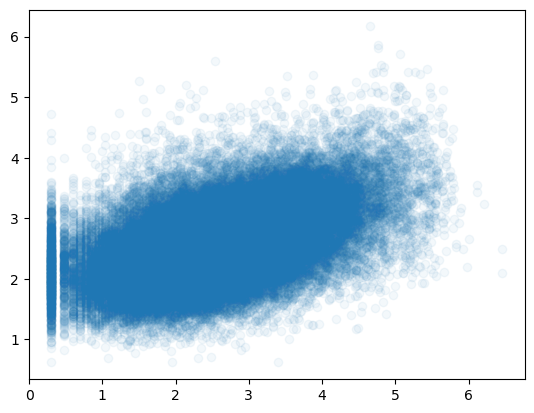

In [35]:
import matplotlib.pyplot as plt
def convert(x):
    return 10**x -1
tlist = [[], []]
pred = np.matmul(clf.game_weights, clf.user_weights)
for i, j in clf.fe_valid:
    tlist[0].append(clf.df.iat[i,j])
    tlist[1].append(pred[i, j])
plt.scatter(x=tlist[0], y= tlist[1], alpha=0.05)
plt.show()

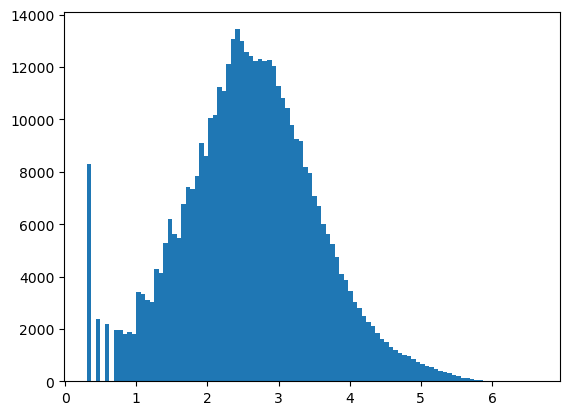

In [11]:
# Data seems to be normally distributed by log. 

tlist = []
for i in range(len(clf.filled_entries)):
    j, k = clf.filled_entries[i]
    tlist.append(log_df.iat[j, k])
import matplotlib.pyplot as plt
plt.hist(tlist, bins=100)
#plt.yscale('log')
plt.show()